 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Import-modules-classes" data-toc-modified-id="Import-modules-classes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import modules classes</a></span></li><li><span><a href="#create-database" data-toc-modified-id="create-database-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>create database</a></span></li><li><span><a href="#Valuation" data-toc-modified-id="Valuation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Valuation</a></span></li><li><span><a href="#可視化" data-toc-modified-id="可視化-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>可視化</a></span></li></ul></div>

In [ ]:
BASEFILE = 'Movie2/'

### Import modules classes

In [2]:
import pandas as pd
import datetime
import cv2
import pickle
import numpy as np
import time
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from scipy import stats
from collections import Counter

%matplotlib inline

# ビデオの読み込み(VideoCapture()に動画ファイルを指定したパターン)
video = cv2.VideoCapture("mouse.avi")
cap = cv2.VideoCapture("mouse.avi")            # 動画を読み込む
video_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT) # フレーム数を取得する
print('frame:', video_frame)
video_fps = cap.get(cv2.CAP_PROP_FPS)           # FPS を取得する
print('fps:', video_fps)
video_len_sec = video_frame / video_fps         # 長さ（秒）を計算する
print(video_len_sec)                            # 長さ（秒）を出力する


frame: 65401.0
fps: 15.019976568836553
4354.267778


### create database

In [18]:
def create_df_from_pickle(pickle_file, flag_df):
    with open(BASEFILE + pickle_file, 'rb') as f:
        results_ = pickle.load(f)
    if len(results_[0]) == 6:
        results = pd.DataFrame(columns=['movie', 'count', 'th30','th50','th100', 'th150'], data=results_)
    else:
        results = pd.DataFrame(columns=['movie', 'count', 'th50', 'th100'], data=results_)
    start_time = datetime.datetime.strptime(pickle_file , 'video_Record-%Y-%m-%d_%H-%M-%S.avi.pickle')
    time_per_frame =  datetime.timedelta(seconds= 1/ video_fps)
    results['datetime'] = [start_time + time_per_frame * (i+1)  for i in results.index]
    frame_flag_dates = []
    flags = []
    for frame_date in tqdm(results['datetime'].values):
        frame_flag_date = pd.to_datetime(frame_date) - (pd.to_datetime(frame_date)  - datetime.datetime(2018, 2,15, 8) ) % datetime.timedelta(seconds=8)
        flag = flag_df[flag_df['datetime'].isin([frame_flag_date])]['flag'].values
        if list(flag) == []:
            flags.append(None)
        else:
            flags.append(flag[0])
        frame_flag_dates.append(frame_flag_date)
    results['flag_datetime'] = frame_flag_dates
    results['flag'] = flags
    return results

In [19]:
movies

['Record-2018-02-24_08-13-38.avi',
 'Record-2018-02-24_09-25-42.avi',
 'Record-2018-02-24_10-36-58.avi',
 'Record-2018-02-24_11-47-09.avi',
 'Record-2018-02-24_12-57-43.avi']

In [27]:
BASEFILE = 'Movie5/'
movies = !ls $BASEFILE | grep .avi | grep -v pickle
pickles =  !ls $BASEFILE | grep .avi | grep  pickle
csv_file = !ls $BASEFILE | grep csv
_df = pd.read_csv(BASEFILE + csv_file[0], header=6)
_df['time'] = ['{}:{}:{}'.format(i*8//3600, ( i * 8 //60) % 60, i * 8 %60) for i in _df.index]
_df['flag'] = [0 if flag == 'Wake' else (1 if flag =='REM' else 2) for flag in _df[_df.columns[0]]]
_df['datetime'] = [datetime.datetime(2018, 2, 15, 8) +  datetime.timedelta(seconds=i * 8) for i in _df.index]

In [15]:
# _df

In [28]:
dfs = [create_df_from_pickle(pickle_file, _df) for pickle_file in pickles]

100%|██████████| 63547/63547 [01:18<00:00, 808.06it/s]


In [29]:
df_merged = pd.concat(dfs)
df_merged = df_merged.dropna()
df_merged = df_merged[df_merged['th100'] < 10000]
df_merged = df_merged[df_merged['th50'] < 40000]
with open('video_result_mouse5.pickle', 'wb') as f:
    pickle.dump(df_merged, f)


### Valuation

In [21]:
result_list = !ls | grep mouse | grep .pickle
result_list

['video_result_mouse.pickle',
 'video_result_mouse2.pickle',
 'video_result_mouse3.pickle',
 'video_result_mouse4.pickle',
 'video_result_mouse5.pickle']

In [25]:
with open(result_list[4], 'rb') as f:
    result = pickle.load(f)
result

,movie,count,th30,th50,th100,th150,datetime,flag_datetime,flag


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


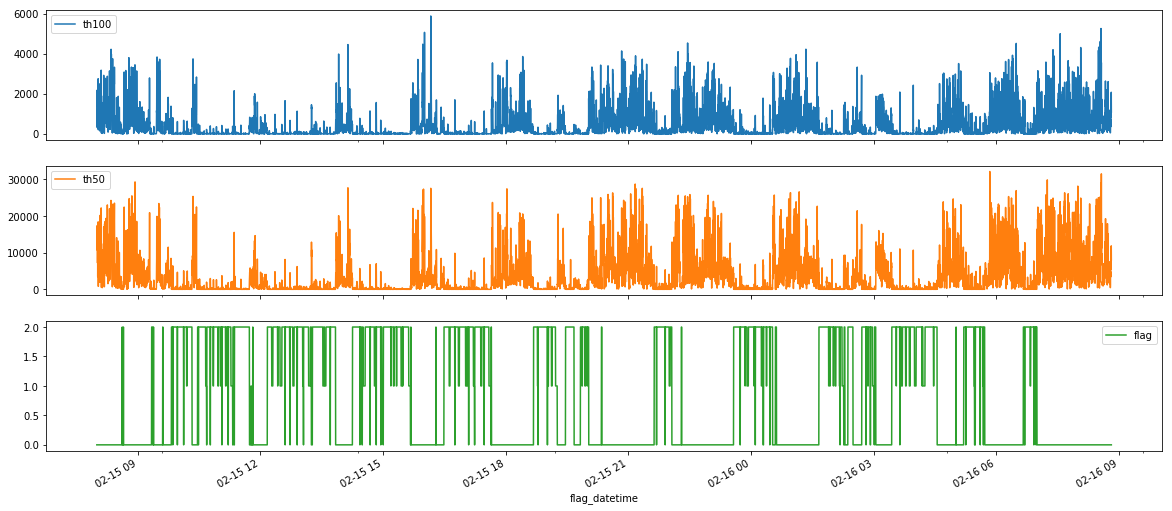

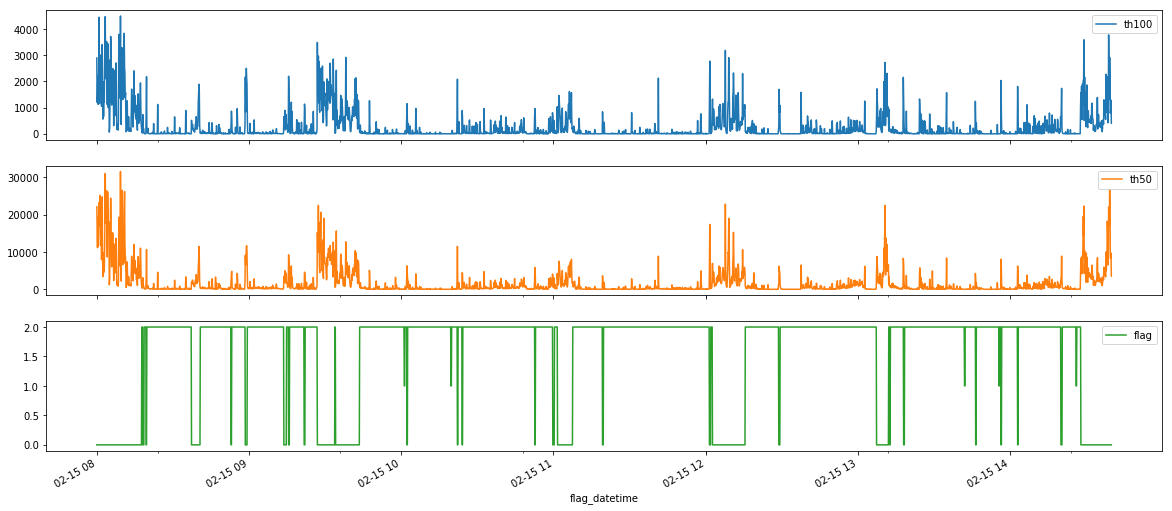

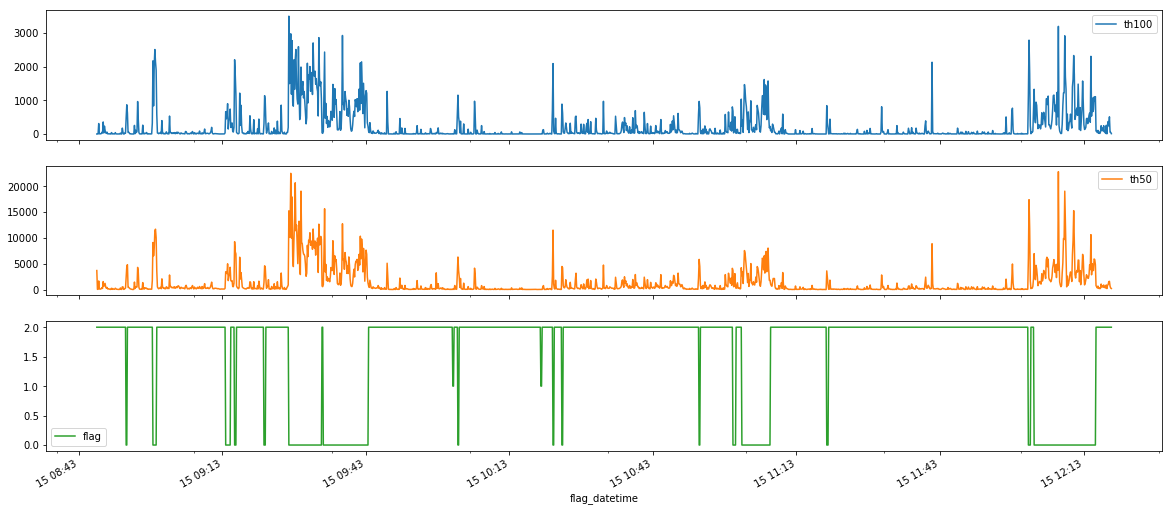

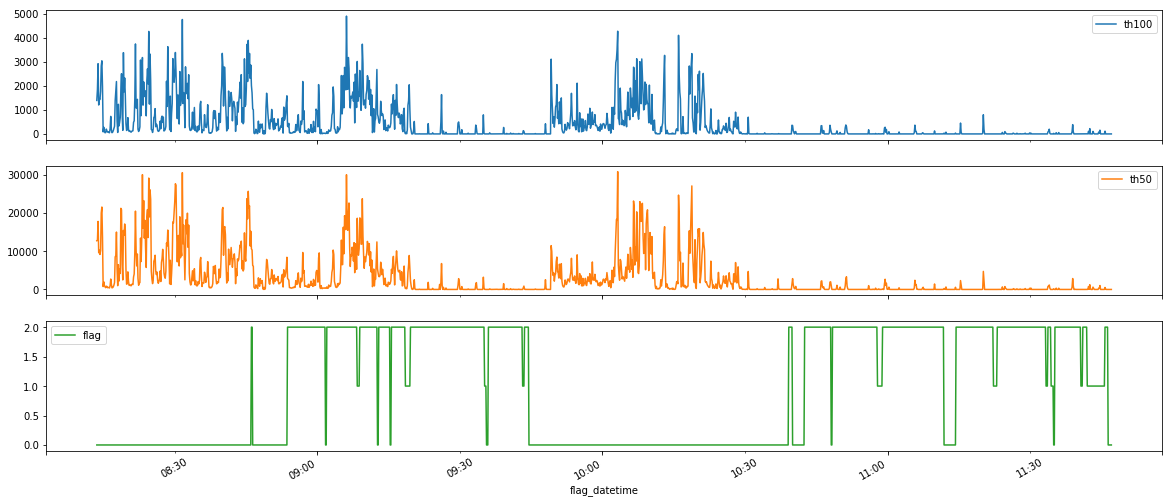

In [216]:
result_df_list = []
grouped_table_list = []
for result in result_list:
    with open(result, 'rb') as f:
        result = pickle.load(f)
    result = result.dropna()
    result = result[result['th100'] < 10000]
    result = result[result['th50'] < 40000]
    result_df_list.append(result)
    grouped_table = pd.DataFrame(result.groupby(['flag_datetime'])['th100', 'th50', 'flag'].mean())
    grouped_table.plot(y = ['th100', 'th50', 'flag'], subplots=True, figsize=(20,9))
    grouped_table_list.append(grouped_table)

In [218]:
for result in  result_df_list:
    print(Counter(result['flag'].values))

Counter({0.0: 716722, 2.0: 533200, 1.0: 74254})
Counter({2.0: 284484, 0.0: 72807, 1.0: 1201})
Counter({2: 153496, 0: 36467, 1: 480})
Counter({2: 91804, 0: 90081, 1: 8413})


In [280]:
def create_classifier_from_xy(x,y, label):
    X = scipy.stats.zscore(x)
    data_x = pd.DataFrame(X)
    clf = AdaBoostClassifier()
    clf.fit(data_x, data_y)
    scores = cross_val_score(clf, data_x, data_y,cv=5)
    print("{}::Cross validation scores:{}".format(label, scores))
    print("{}::Cross validation scores:{}".format(label, scores.mean()))
    return clf, scores.mean()

def create_classifiers(result_dfs):
    classifier_dict = {}
    classifier_array = []
    patterns =  [list(i) for i in combinations(cols, 2)]
    for i, result_table in enumerate(result_dfs):
        # 8秒毎のグルーピング
        grouped_table_median = pd.DataFrame(data=result_table.groupby(['flag_datetime'])['flag', 'th100', 'th50'].median().values, columns=['flag', 'th100_median', 'th50_median', ])
        grouped_table_sum = pd.DataFrame(result_table.groupby(['flag_datetime'])['th100', 'th50', ].sum().values, columns=['th100_sum', 'th50_sum'])
        grouped_table_min = pd.DataFrame(result_table.groupby(['flag_datetime'])['th100', 'th50', ].min().values, columns=['th100_min', 'th50_min'])
        grouped_table_max = pd.DataFrame(result_table.groupby(['flag_datetime'])['th100', 'th50', ].max().values, columns=['th100_max', 'th50_max'])
        grouped_table_mean= pd.DataFrame(result_table.groupby(['flag_datetime'])['th100', 'th50', ].mean().values, columns=['th100_mean', 'th50_mean'])
        table_merged = pd.concat([grouped_table_median, grouped_table_max, grouped_table_mean, grouped_table_min, grouped_table_sum], axis=1)    
        for pattern in tqdm(patterns):
            x = table_merged[pattern].values
            data_x = pd.DataFrame(x).values
            y = table_merged['flag'].values
            data_y = pd.DataFrame(y, columns=['target']).values.ravel()
            data_y = [1 if i > 0 else 0 for i in data_y]
            clf = AdaBoostClassifier()
            clf.fit(data_x, data_y)
            scores = cross_val_score(clf, data_x, data_y, cv=5)
            print("{}::Cross validation scores:{}".format(str(pattern), scores))
            print("{}::Cross validation scores:{}".format(str(pattern), scores.mean()))
            classifier_dict.update({str(i) + str(pattern) : clf})
            classifier_array.append([str(i), str(pattern), clf, data_x, data_y])
    classifier_df = pd.DataFrame(data=classifier_array, columns=['source', 'pattern', 'clf', 'x', 'y'])
    # classifierの性能診断
    results_all = []
    for pattern in patterns:
        use_rows = classifier_df[[str(pattern) == k  for k in classifier_df['pattern'].values]].values
        clf_results = []
        for row in use_rows:
            clf = row[2]
            clf_results.append([clf.score(row[3], row[4]) for row in use_rows])
#         classifier_keys = [k for k, v in classifier_dict.items() if pattern in k ]
        results_all.append([pattern, clf_results])
    return results_all, classifier_df

In [283]:
results, classifier_df = create_classifiers(result_df_list)

  0%|          | 0/45 [00:00<?, ?it/s]/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  2%|▏         | 1/45 [00:01<00:49,  1.12s/it]

['th100_median', 'th50_median']::Cross validation scores:[0.92972247 0.95120859 0.97268249 0.95656068 0.95118674]
['th100_median', 'th50_median']::Cross validation scores:0.9522721960532599


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  4%|▍         | 2/45 [00:02<00:46,  1.09s/it]

['th100_median', 'th100_max']::Cross validation scores:[0.91316025 0.9301701  0.97402597 0.9632781  0.96462159]
['th100_median', 'th100_max']::Cross validation scores:0.9490512019391716


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  7%|▋         | 3/45 [00:03<00:45,  1.09s/it]

['th100_median', 'th50_max']::Cross validation scores:[0.91181737 0.92972247 0.97357815 0.96059113 0.96372593]
['th100_median', 'th50_max']::Cross validation scores:0.9478870094188219


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  9%|▉         | 4/45 [00:04<00:44,  1.09s/it]

['th100_median', 'th100_mean']::Cross validation scores:[0.91316025 0.9301701  0.97357815 0.9632781  0.96417376]
['th100_median', 'th100_mean']::Cross validation scores:0.9488720707255576


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 11%|█         | 5/45 [00:05<00:44,  1.10s/it]

['th100_median', 'th50_mean']::Cross validation scores:[0.91316025 0.9301701  0.97492163 0.96238245 0.96417376]
['th100_median', 'th50_mean']::Cross validation scores:0.9489616363323645


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 13%|█▎        | 6/45 [00:06<00:41,  1.08s/it]

['th100_median', 'th100_min']::Cross validation scores:[0.91316025 0.9301701  0.97357815 0.9632781  0.96417376]
['th100_median', 'th100_min']::Cross validation scores:0.9488720707255576


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 16%|█▌        | 7/45 [00:07<00:40,  1.07s/it]

['th100_median', 'th50_min']::Cross validation scores:[0.93285586 0.95389436 0.98343036 0.97044335 0.97357815]
['th100_median', 'th50_min']::Cross validation scores:0.9628404164600257


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 18%|█▊        | 8/45 [00:08<00:39,  1.07s/it]

['th100_median', 'th100_sum']::Cross validation scores:[0.91316025 0.9301701  0.9744738  0.9632781  0.96417376]
['th100_median', 'th100_sum']::Cross validation scores:0.9490512019391716


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 20%|██        | 9/45 [00:09<00:38,  1.07s/it]

['th100_median', 'th50_sum']::Cross validation scores:[0.91316025 0.9301701  0.9744738  0.96238245 0.96417376]
['th100_median', 'th50_sum']::Cross validation scores:0.9488720707255578


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 22%|██▏       | 10/45 [00:10<00:37,  1.08s/it]

['th50_median', 'th100_max']::Cross validation scores:[0.92882722 0.95120859 0.97357815 0.9601433  0.95611285]
['th50_median', 'th100_max']::Cross validation scores:0.9539740227666631


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 24%|██▍       | 11/45 [00:11<00:36,  1.09s/it]

['th50_median', 'th50_max']::Cross validation scores:[0.92972247 0.9529991  0.97268249 0.9601433  0.95790416]
['th50_median', 'th50_max']::Cross validation scores:0.9546903070689075


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 27%|██▋       | 12/45 [00:13<00:36,  1.09s/it]

['th50_median', 'th100_mean']::Cross validation scores:[0.92972247 0.95120859 0.97268249 0.95566502 0.95118674]
['th50_median', 'th100_mean']::Cross validation scores:0.9520930648396458


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 29%|██▉       | 13/45 [00:14<00:35,  1.10s/it]

['th50_median', 'th50_mean']::Cross validation scores:[0.93688451 0.95120859 0.97268249 0.95611285 0.95118674]
['th50_median', 'th50_mean']::Cross validation scores:0.9536150386828002


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 31%|███       | 14/45 [00:15<00:33,  1.09s/it]

['th50_median', 'th100_min']::Cross validation scores:[0.92972247 0.95120859 0.97268249 0.95566502 0.95118674]
['th50_median', 'th100_min']::Cross validation scores:0.9520930648396458


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 33%|███▎      | 15/45 [00:16<00:32,  1.09s/it]

['th50_median', 'th50_min']::Cross validation scores:[0.93375112 0.95434199 0.98298253 0.97268249 0.97402597]
['th50_median', 'th50_min']::Cross validation scores:0.9635568210383758


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 36%|███▌      | 16/45 [00:17<00:31,  1.09s/it]

['th50_median', 'th100_sum']::Cross validation scores:[0.92927484 0.95120859 0.97223466 0.95656068 0.95073892]
['th50_median', 'th100_sum']::Cross validation scores:0.9520035393248742


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 38%|███▊      | 17/45 [00:18<00:30,  1.10s/it]

['th50_median', 'th50_sum']::Cross validation scores:[0.92972247 0.95120859 0.97223466 0.95790416 0.95118674]
['th50_median', 'th50_sum']::Cross validation scores:0.9524513272668738


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 40%|████      | 18/45 [00:19<00:29,  1.10s/it]

['th100_max', 'th50_max']::Cross validation scores:[0.8652641  0.88809311 0.93551276 0.9072996  0.90192566]
['th100_max', 'th50_max']::Cross validation scores:0.8996190454808056


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 42%|████▏     | 19/45 [00:21<00:28,  1.11s/it]

['th100_max', 'th100_mean']::Cross validation scores:[0.88227395 0.89749329 0.95700851 0.93327362 0.92745186]
['th100_max', 'th100_mean']::Cross validation scores:0.9195002447618753


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 44%|████▍     | 20/45 [00:22<00:27,  1.11s/it]

['th100_max', 'th50_mean']::Cross validation scores:[0.89346464 0.93375112 0.96148679 0.94626064 0.93864756]
['th100_max', 'th50_mean']::Cross validation scores:0.9347221481633238


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 47%|████▋     | 21/45 [00:23<00:26,  1.10s/it]

['th100_max', 'th100_min']::Cross validation scores:[0.86123545 0.87197851 0.90326914 0.89834304 0.87550381]
['th100_max', 'th100_min']::Cross validation scores:0.882065990688224


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 49%|████▉     | 22/45 [00:24<00:25,  1.10s/it]

['th100_max', 'th50_min']::Cross validation scores:[0.93240824 0.95434199 0.98432602 0.96999552 0.96954769]
['th100_max', 'th50_min']::Cross validation scores:0.9621238916055697


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 51%|█████     | 23/45 [00:25<00:24,  1.10s/it]

['th100_max', 'th100_sum']::Cross validation scores:[0.89301701 0.89838854 0.95566502 0.93282579 0.93237797]
['th100_max', 'th100_sum']::Cross validation scores:0.9224548673935887


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 53%|█████▎    | 24/45 [00:26<00:23,  1.11s/it]

['th100_max', 'th50_sum']::Cross validation scores:[0.89346464 0.93240824 0.9601433  0.94267801 0.94581281]
['th100_max', 'th50_sum']::Cross validation scores:0.9349013996530434


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 56%|█████▌    | 25/45 [00:27<00:22,  1.11s/it]

['th50_max', 'th100_mean']::Cross validation scores:[0.87958818 0.88495971 0.94715629 0.92252575 0.91715181]
['th50_max', 'th100_mean']::Cross validation scores:0.9102763503899552


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 58%|█████▊    | 26/45 [00:28<00:21,  1.11s/it]

['th50_max', 'th50_mean']::Cross validation scores:[0.91316025 0.93643688 0.96193462 0.9377519  0.9408867 ]
['th50_max', 'th50_mean']::Cross validation scores:0.9380340710134183


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 60%|██████    | 27/45 [00:29<00:19,  1.11s/it]

['th50_max', 'th100_min']::Cross validation scores:[0.86705461 0.88854073 0.94536498 0.91491267 0.90371697]
['th50_max', 'th100_min']::Cross validation scores:0.9039179941473646


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 62%|██████▏   | 28/45 [00:31<00:18,  1.11s/it]

['th50_max', 'th50_min']::Cross validation scores:[0.93196061 0.95568487 0.98387819 0.96909987 0.97089118]
['th50_max', 'th50_min']::Cross validation scores:0.9623029426351133


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 64%|██████▍   | 29/45 [00:32<00:17,  1.11s/it]

['th50_max', 'th100_sum']::Cross validation scores:[0.88093107 0.88451209 0.95118674 0.92342141 0.92252575]
['th50_max', 'th100_sum']::Cross validation scores:0.9125154103760593


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 67%|██████▋   | 30/45 [00:33<00:16,  1.11s/it]

['th50_max', 'th50_sum']::Cross validation scores:[0.91629364 0.93554163 0.95924765 0.94043887 0.94491715]
['th50_max', 'th50_sum']::Cross validation scores:0.9392877890485398


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 69%|██████▉   | 31/45 [00:34<00:15,  1.12s/it]

['th100_mean', 'th50_mean']::Cross validation scores:[0.89525515 0.92032229 0.96551724 0.93640842 0.93640842]
['th100_mean', 'th50_mean']::Cross validation scores:0.9307823038567336


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 71%|███████   | 32/45 [00:35<00:14,  1.11s/it]

['th100_mean', 'th100_min']::Cross validation scores:[0.88137869 0.8863026  0.95700851 0.92521272 0.92297358]
['th100_mean', 'th100_min']::Cross validation scores:0.9145752188724436


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 73%|███████▎  | 33/45 [00:36<00:13,  1.11s/it]

['th100_mean', 'th50_min']::Cross validation scores:[0.93240824 0.95478962 0.98477385 0.97133901 0.97178683]
['th100_mean', 'th50_min']::Cross validation scores:0.9630195075816044


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 76%|███████▌  | 34/45 [00:37<00:12,  1.12s/it]

['th100_mean', 'th100_sum']::Cross validation scores:[0.88137869 0.8863026  0.95700851 0.92521272 0.92297358]
['th100_mean', 'th100_sum']::Cross validation scores:0.9145752188724436


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 78%|███████▊  | 35/45 [00:39<00:11,  1.12s/it]

['th100_mean', 'th50_sum']::Cross validation scores:[0.89435989 0.92032229 0.96372593 0.93685625 0.93730408]
['th100_mean', 'th50_sum']::Cross validation scores:0.930513687220383


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 80%|████████  | 36/45 [00:40<00:10,  1.12s/it]

['th50_mean', 'th100_min']::Cross validation scores:[0.89570278 0.91987466 0.96551724 0.93819973 0.93999104]
['th50_mean', 'th100_min']::Cross validation scores:0.9318570911384174


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 82%|████████▏ | 37/45 [00:41<00:08,  1.12s/it]

['th50_mean', 'th50_min']::Cross validation scores:[0.93330349 0.95478962 0.98387819 0.97044335 0.97133901]
['th50_mean', 'th50_min']::Cross validation scores:0.9627507305771129


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 84%|████████▍ | 38/45 [00:42<00:07,  1.12s/it]

['th50_mean', 'th100_sum']::Cross validation scores:[0.89570278 0.91987466 0.96551724 0.93596059 0.93596059]
['th50_mean', 'th100_sum']::Cross validation scores:0.9306031726431195


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 87%|████████▋ | 39/45 [00:43<00:06,  1.12s/it]

['th50_mean', 'th50_sum']::Cross validation scores:[0.89525515 0.91987466 0.96506941 0.93819973 0.93954322]
['th50_mean', 'th50_sum']::Cross validation scores:0.9315884344100317


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 89%|████████▉ | 40/45 [00:44<00:05,  1.12s/it]

['th100_min', 'th50_min']::Cross validation scores:[0.93240824 0.95389436 0.98343036 0.97044335 0.97402597]
['th100_min', 'th50_min']::Cross validation scores:0.962840456552061


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 91%|█████████ | 41/45 [00:45<00:04,  1.11s/it]

['th100_min', 'th100_sum']::Cross validation scores:[0.88227395 0.8863026  0.95700851 0.92431706 0.92297358]
['th100_min', 'th100_sum']::Cross validation scores:0.9145751386883731


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 93%|█████████▎| 42/45 [00:46<00:03,  1.11s/it]

['th100_min', 'th50_sum']::Cross validation scores:[0.89525515 0.91987466 0.96462159 0.93819973 0.93999104]
['th100_min', 'th50_sum']::Cross validation scores:0.9315884344100318


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 96%|█████████▌| 43/45 [00:47<00:02,  1.11s/it]

['th50_min', 'th100_sum']::Cross validation scores:[0.93240824 0.95478962 0.98477385 0.97178683 0.97178683]
['th50_min', 'th100_sum']::Cross validation scores:0.9631090731884113


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 98%|█████████▊| 44/45 [00:48<00:01,  1.11s/it]

['th50_min', 'th50_sum']::Cross validation scores:[0.93330349 0.95478962 0.98298253 0.97044335 0.97133901]
['th50_min', 'th50_sum']::Cross validation scores:0.9625715993634989


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  0%|          | 0/45 [00:00<?, ?it/s]

['th100_sum', 'th50_sum']::Cross validation scores:[0.89480752 0.92032229 0.96551724 0.93506494 0.93730408]
['th100_sum', 'th50_sum']::Cross validation scores:0.9306032127351548


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  2%|▏         | 1/45 [00:00<00:22,  2.00it/s]

['th100_median', 'th50_median']::Cross validation scores:[0.95174709 0.94166667 0.93333333 0.90317195 0.93155259]
['th100_median', 'th50_median']::Cross validation scores:0.9322943258175718


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  4%|▍         | 2/45 [00:01<00:21,  1.98it/s]

['th100_median', 'th100_max']::Cross validation scores:[0.96173045 0.94       0.93       0.91819699 0.92654424]
['th100_median', 'th100_max']::Cross validation scores:0.9352943369287138


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  7%|▋         | 3/45 [00:01<00:21,  1.97it/s]

['th100_median', 'th50_max']::Cross validation scores:[0.95840266 0.94333333 0.93       0.92153589 0.93155259]
['th100_median', 'th50_max']::Cross validation scores:0.9369648952728573


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  9%|▉         | 4/45 [00:02<00:20,  1.97it/s]

['th100_median', 'th100_mean']::Cross validation scores:[0.96006656 0.94166667 0.93166667 0.92153589 0.93155259]
['th100_median', 'th100_mean']::Cross validation scores:0.9372976739750202


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 11%|█         | 5/45 [00:02<00:20,  1.97it/s]

['th100_median', 'th50_mean']::Cross validation scores:[0.96006656 0.93833333 0.93333333 0.9148581  0.92988314]
['th100_median', 'th50_mean']::Cross validation scores:0.9352948915598841


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 13%|█▎        | 6/45 [00:02<00:19,  2.01it/s]

['th100_median', 'th100_min']::Cross validation scores:[0.96173045 0.94       0.93333333 0.91986644 0.92988314]
['th100_median', 'th100_min']::Cross validation scores:0.936962673044462


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 16%|█▌        | 7/45 [00:03<00:18,  2.03it/s]

['th100_median', 'th50_min']::Cross validation scores:[0.97670549 0.94       0.93666667 0.91318865 0.95158598]
['th100_median', 'th50_min']::Cross validation scores:0.9436293563778417


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 18%|█▊        | 8/45 [00:03<00:18,  2.02it/s]

['th100_median', 'th100_sum']::Cross validation scores:[0.96173045 0.93833333 0.93166667 0.91986644 0.93155259]
['th100_median', 'th100_sum']::Cross validation scores:0.9366298961941562


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 20%|██        | 9/45 [00:04<00:17,  2.02it/s]

['th100_median', 'th50_sum']::Cross validation scores:[0.96006656 0.94333333 0.935      0.91318865 0.93322204]
['th100_median', 'th50_sum']::Cross validation scores:0.9369621147095779


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 22%|██▏       | 10/45 [00:04<00:17,  2.01it/s]

['th50_median', 'th100_max']::Cross validation scores:[0.95008319 0.94       0.91666667 0.9115192  0.94490818]
['th50_median', 'th100_max']::Cross validation scores:0.9326354480614297


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 24%|██▍       | 11/45 [00:05<00:16,  2.00it/s]

['th50_median', 'th50_max']::Cross validation scores:[0.95008319 0.93666667 0.91833333 0.89649416 0.94323873]
['th50_median', 'th50_max']::Cross validation scores:0.9289632165644905


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 27%|██▋       | 12/45 [00:06<00:16,  1.99it/s]

['th50_median', 'th100_mean']::Cross validation scores:[0.9484193  0.94333333 0.91333333 0.9048414  0.95325543]
['th50_median', 'th100_mean']::Cross validation scores:0.9326365591756274


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 29%|██▉       | 13/45 [00:06<00:16,  1.99it/s]

['th50_median', 'th50_mean']::Cross validation scores:[0.95341098 0.94166667 0.915      0.90984975 0.94824708]
['th50_median', 'th50_mean']::Cross validation scores:0.9336348952821165


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 31%|███       | 14/45 [00:07<00:15,  1.99it/s]

['th50_median', 'th100_min']::Cross validation scores:[0.95174709 0.93666667 0.92166667 0.9115192  0.94490818]
['th50_median', 'th100_min']::Cross validation scores:0.9333015600969261


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 33%|███▎      | 15/45 [00:07<00:15,  1.99it/s]

['th50_median', 'th50_min']::Cross validation scores:[0.97004992 0.94333333 0.92833333 0.91318865 0.94991653]
['th50_median', 'th50_min']::Cross validation scores:0.940964351752829


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 36%|███▌      | 16/45 [00:08<00:14,  1.99it/s]

['th50_median', 'th100_sum']::Cross validation scores:[0.9484193  0.945      0.91833333 0.90317195 0.94490818]
['th50_median', 'th100_sum']::Cross validation scores:0.931966553610797


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 38%|███▊      | 17/45 [00:08<00:14,  1.98it/s]

['th50_median', 'th50_sum']::Cross validation scores:[0.95341098 0.94333333 0.915      0.89649416 0.94156928]
['th50_median', 'th50_sum']::Cross validation scores:0.9299615508191227


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 40%|████      | 18/45 [00:09<00:13,  1.98it/s]

['th100_max', 'th50_max']::Cross validation scores:[0.9234609  0.89833333 0.90833333 0.86811352 0.92487479]
['th100_max', 'th50_max']::Cross validation scores:0.904623175805118


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 42%|████▏     | 19/45 [00:09<00:13,  1.97it/s]

['th100_max', 'th100_mean']::Cross validation scores:[0.93843594 0.925      0.915      0.89983306 0.89983306]
['th100_max', 'th100_mean']::Cross validation scores:0.9156204100566946


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 44%|████▍     | 20/45 [00:10<00:12,  1.97it/s]

['th100_max', 'th50_mean']::Cross validation scores:[0.94675541 0.93       0.91833333 0.90317195 0.94657763]
['th100_max', 'th50_mean']::Cross validation scores:0.9289676647249946


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 47%|████▋     | 21/45 [00:10<00:12,  1.98it/s]

['th100_max', 'th100_min']::Cross validation scores:[0.96339434 0.94666667 0.91166667 0.9081803  0.93823038]
['th100_max', 'th100_min']::Cross validation scores:0.933627672113904


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 49%|████▉     | 22/45 [00:11<00:11,  1.98it/s]

['th100_max', 'th50_min']::Cross validation scores:[0.9733777  0.92833333 0.93166667 0.91318865 0.94657763]
['th100_max', 'th50_min']::Cross validation scores:0.9386287961911005


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 51%|█████     | 23/45 [00:11<00:11,  1.98it/s]

['th100_max', 'th100_sum']::Cross validation scores:[0.94009983 0.91833333 0.91333333 0.89816361 0.90984975]
['th100_max', 'th100_sum']::Cross validation scores:0.9159559711739942


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 53%|█████▎    | 24/45 [00:12<00:10,  1.97it/s]

['th100_max', 'th50_sum']::Cross validation scores:[0.94675541 0.925      0.92166667 0.9015025  0.94657763]
['th100_max', 'th50_sum']::Cross validation scores:0.9283004415753007


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 56%|█████▌    | 25/45 [00:12<00:10,  1.97it/s]

['th50_max', 'th100_mean']::Cross validation scores:[0.9234609  0.89833333 0.90666667 0.88480801 0.87646077]
['th50_max', 'th100_mean']::Cross validation scores:0.8979459359609333


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 58%|█████▊    | 26/45 [00:13<00:09,  1.96it/s]

['th50_max', 'th50_mean']::Cross validation scores:[0.93843594 0.92166667 0.91833333 0.9015025  0.92988314]
['th50_max', 'th50_mean']::Cross validation scores:0.9219643165675461


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 60%|██████    | 27/45 [00:13<00:09,  1.96it/s]

['th50_max', 'th100_min']::Cross validation scores:[0.96006656 0.94666667 0.915      0.9115192  0.94657763]
['th50_max', 'th100_min']::Cross validation scores:0.9359660100907687


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 62%|██████▏   | 28/45 [00:14<00:08,  1.96it/s]

['th50_max', 'th50_min']::Cross validation scores:[0.9750416  0.93333333 0.92833333 0.91986644 0.95993322]
['th50_max', 'th50_min']::Cross validation scores:0.9433015860229241


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 64%|██████▍   | 29/45 [00:14<00:08,  1.96it/s]

['th50_max', 'th100_sum']::Cross validation scores:[0.92512479 0.91166667 0.88666667 0.88480801 0.88647746]
['th50_max', 'th100_sum']::Cross validation scores:0.8989487202279266


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 67%|██████▋   | 30/45 [00:15<00:07,  1.96it/s]

['th50_max', 'th50_sum']::Cross validation scores:[0.94009983 0.93166667 0.91833333 0.89649416 0.93489149]
['th50_max', 'th50_sum']::Cross validation scores:0.924297095269709


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 69%|██████▉   | 31/45 [00:15<00:07,  1.95it/s]

['th100_mean', 'th50_mean']::Cross validation scores:[0.94009983 0.935      0.91166667 0.89983306 0.94323873]
['th100_mean', 'th50_mean']::Cross validation scores:0.9259676573175666


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 71%|███████   | 32/45 [00:16<00:06,  1.95it/s]

['th100_mean', 'th100_min']::Cross validation scores:[0.96006656 0.94166667 0.91833333 0.90984975 0.93489149]
['th100_mean', 'th100_min']::Cross validation scores:0.9329615582265506


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 73%|███████▎  | 33/45 [00:16<00:06,  1.95it/s]

['th100_mean', 'th50_min']::Cross validation scores:[0.97670549 0.91666667 0.92833333 0.9048414  0.95158598]
['th100_mean', 'th50_min']::Cross validation scores:0.9356265739627053


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 76%|███████▌  | 34/45 [00:17<00:05,  1.95it/s]

['th100_mean', 'th100_sum']::Cross validation scores:[0.93011647 0.90166667 0.91       0.88313856 0.88313856]
['th100_mean', 'th100_sum']::Cross validation scores:0.9016120535520006


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 78%|███████▊  | 35/45 [00:17<00:05,  1.95it/s]

['th100_mean', 'th50_sum']::Cross validation scores:[0.94342762 0.925      0.92       0.89816361 0.94824708]
['th100_mean', 'th50_sum']::Cross validation scores:0.9269676610212807


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 80%|████████  | 36/45 [00:18<00:04,  1.95it/s]

['th50_mean', 'th100_min']::Cross validation scores:[0.95341098 0.93833333 0.92       0.9148581  0.95325543]
['th50_mean', 'th100_min']::Cross validation scores:0.9359715675136135


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 82%|████████▏ | 37/45 [00:18<00:04,  1.95it/s]

['th50_mean', 'th50_min']::Cross validation scores:[0.97004992 0.93166667 0.93       0.90984975 0.95993322]
['th50_mean', 'th50_min']::Cross validation scores:0.9402999110182714


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 84%|████████▍ | 38/45 [00:19<00:03,  1.95it/s]

['th50_mean', 'th100_sum']::Cross validation scores:[0.94509151 0.92666667 0.915      0.88647746 0.93989983]
['th50_mean', 'th100_sum']::Cross validation scores:0.9226270952604498


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 87%|████████▋ | 39/45 [00:20<00:03,  1.94it/s]

['th50_mean', 'th50_sum']::Cross validation scores:[0.93843594 0.915      0.91333333 0.90317195 0.92654424]
['th50_mean', 'th50_sum']::Cross validation scores:0.919297093417852


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 89%|████████▉ | 40/45 [00:20<00:02,  1.95it/s]

['th100_min', 'th50_min']::Cross validation scores:[0.97836938 0.91333333 0.93833333 0.9048414  0.95325543]
['th100_min', 'th50_min']::Cross validation scores:0.9376265758145624


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 91%|█████████ | 41/45 [00:20<00:02,  1.95it/s]

['th100_min', 'th100_sum']::Cross validation scores:[0.96006656 0.93666667 0.92       0.90651085 0.93489149]
['th100_min', 'th100_sum']::Cross validation scores:0.9316271119271627


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 93%|█████████▎| 42/45 [00:21<00:01,  1.96it/s]

['th100_min', 'th50_sum']::Cross validation scores:[0.95507488 0.94166667 0.925      0.91652755 0.95158598]
['th100_min', 'th50_sum']::Cross validation scores:0.9379710128824431


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 96%|█████████▌| 43/45 [00:21<00:01,  1.96it/s]

['th50_min', 'th100_sum']::Cross validation scores:[0.97670549 0.93333333 0.935      0.90317195 0.95158598]
['th50_min', 'th100_sum']::Cross validation scores:0.9399593508130115


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 98%|█████████▊| 44/45 [00:22<00:00,  1.96it/s]

['th50_min', 'th50_sum']::Cross validation scores:[0.97004992 0.92666667 0.93       0.9115192  0.95993322]
['th50_min', 'th50_sum']::Cross validation scores:0.9396338008346319


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  0%|          | 0/45 [00:00<?, ?it/s]

['th100_sum', 'th50_sum']::Cross validation scores:[0.94176373 0.92833333 0.91833333 0.88981636 0.94991653]
['th100_sum', 'th50_sum']::Cross validation scores:0.9256326563870084


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  2%|▏         | 1/45 [00:00<00:17,  2.48it/s]

['th100_median', 'th50_median']::Cross validation scores:[0.96238245 0.95297806 0.91194969 0.94637224 0.95583596]
['th100_median', 'th50_median']::Cross validation scores:0.9459036777989468


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  4%|▍         | 2/45 [00:00<00:17,  2.45it/s]

['th100_median', 'th100_max']::Cross validation scores:[0.95611285 0.94670846 0.91509434 0.94952681 0.94637224]
['th100_median', 'th100_max']::Cross validation scores:0.9427629419729644


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  7%|▋         | 3/45 [00:01<00:16,  2.48it/s]

['th100_median', 'th50_max']::Cross validation scores:[0.96238245 0.95297806 0.91509434 0.94637224 0.95268139]
['th100_median', 'th50_max']::Cross validation scores:0.9459016937900584


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  9%|▉         | 4/45 [00:01<00:16,  2.45it/s]

['th100_median', 'th100_mean']::Cross validation scores:[0.96238245 0.94984326 0.91194969 0.94952681 0.94321767]
['th100_median', 'th100_mean']::Cross validation scores:0.9433839740718026


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 11%|█         | 5/45 [00:02<00:16,  2.47it/s]

['th100_median', 'th50_mean']::Cross validation scores:[0.96238245 0.95611285 0.91509434 0.94637224 0.95899054]
['th100_median', 'th50_mean']::Cross validation scores:0.9477904826907041


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 13%|█▎        | 6/45 [00:02<00:15,  2.51it/s]

['th100_median', 'th100_min']::Cross validation scores:[0.96238245 0.94984326 0.91194969 0.94952681 0.94321767]
['th100_median', 'th100_min']::Cross validation scores:0.9433839740718026


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 16%|█▌        | 7/45 [00:02<00:15,  2.53it/s]

['th100_median', 'th50_min']::Cross validation scores:[0.97178683 0.96238245 0.91194969 0.94006309 0.95268139]
['th100_median', 'th50_min']::Cross validation scores:0.9477726888053448


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 18%|█▊        | 8/45 [00:03<00:14,  2.53it/s]

['th100_median', 'th100_sum']::Cross validation scores:[0.96238245 0.95611285 0.90880503 0.94952681 0.95583596]
['th100_median', 'th100_sum']::Cross validation scores:0.9465326210554841


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 20%|██        | 9/45 [00:03<00:14,  2.53it/s]

['th100_median', 'th50_sum']::Cross validation scores:[0.96238245 0.95297806 0.91194969 0.94637224 0.95899054]
['th100_median', 'th50_sum']::Cross validation scores:0.9465345926254451


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 22%|██▏       | 10/45 [00:03<00:13,  2.52it/s]

['th50_median', 'th100_max']::Cross validation scores:[0.94670846 0.93730408 0.9245283  0.93059937 0.94952681]
['th50_median', 'th100_max']::Cross validation scores:0.937733404807409


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 24%|██▍       | 11/45 [00:04<00:13,  2.51it/s]

['th50_median', 'th50_max']::Cross validation scores:[0.93103448 0.94043887 0.92138365 0.92429022 0.93690852]
['th50_median', 'th50_max']::Cross validation scores:0.9308111480402129


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 27%|██▋       | 12/45 [00:04<00:13,  2.51it/s]

['th50_median', 'th100_mean']::Cross validation scores:[0.93730408 0.93730408 0.91194969 0.92429022 0.94321767]
['th50_median', 'th100_mean']::Cross validation scores:0.9308131444880283


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 29%|██▉       | 13/45 [00:05<00:12,  2.50it/s]

['th50_median', 'th50_mean']::Cross validation scores:[0.94043887 0.93416928 0.92138365 0.93059937 0.94006309]
['th50_median', 'th50_mean']::Cross validation scores:0.9333308517673571


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 31%|███       | 14/45 [00:05<00:12,  2.51it/s]

['th50_median', 'th100_min']::Cross validation scores:[0.94043887 0.94357367 0.91509434 0.93690852 0.94006309]
['th50_median', 'th100_min']::Cross validation scores:0.9352156975280804


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 33%|███▎      | 15/45 [00:05<00:11,  2.51it/s]

['th50_median', 'th50_min']::Cross validation scores:[0.97492163 0.95924765 0.89622642 0.94321767 0.95583596]
['th50_median', 'th50_min']::Cross validation scores:0.9458898643702914


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 36%|███▌      | 16/45 [00:06<00:11,  2.51it/s]

['th50_median', 'th100_sum']::Cross validation scores:[0.94357367 0.93103448 0.90880503 0.93690852 0.93690852]
['th50_median', 'th100_sum']::Cross validation scores:0.9314460433234151


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 38%|███▊      | 17/45 [00:06<00:11,  2.50it/s]

['th50_median', 'th50_sum']::Cross validation scores:[0.94670846 0.93416928 0.91823899 0.92429022 0.94006309]
['th50_median', 'th50_sum']::Cross validation scores:0.932694009792048


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 40%|████      | 18/45 [00:07<00:10,  2.50it/s]

['th100_max', 'th50_max']::Cross validation scores:[0.91222571 0.91222571 0.85220126 0.88958991 0.91798107]
['th100_max', 'th50_max']::Cross validation scores:0.8968447292875845


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 42%|████▏     | 19/45 [00:07<00:10,  2.49it/s]

['th100_max', 'th100_mean']::Cross validation scores:[0.93416928 0.94984326 0.86163522 0.92113565 0.90536278]
['th100_max', 'th100_mean']::Cross validation scores:0.9144292364047345


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 44%|████▍     | 20/45 [00:08<00:10,  2.48it/s]

['th100_max', 'th50_mean']::Cross validation scores:[0.92789969 0.92476489 0.88679245 0.90851735 0.94321767]
['th100_max', 'th50_mean']::Cross validation scores:0.9182384090811135


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 47%|████▋     | 21/45 [00:08<00:09,  2.49it/s]

['th100_max', 'th100_min']::Cross validation scores:[0.97178683 0.93103448 0.90251572 0.93059937 0.91167192]
['th100_max', 'th100_min']::Cross validation scores:0.9295216666520508


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 49%|████▉     | 22/45 [00:08<00:09,  2.49it/s]

['th100_max', 'th50_min']::Cross validation scores:[0.96551724 0.96551724 0.88050314 0.93375394 0.95268139]
['th100_max', 'th50_min']::Cross validation scores:0.9395945917285985


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 51%|█████     | 23/45 [00:09<00:08,  2.49it/s]

['th100_max', 'th100_sum']::Cross validation scores:[0.93416928 0.94670846 0.86792453 0.92113565 0.9022082 ]
['th100_max', 'th100_sum']::Cross validation scores:0.9144292239658075


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 53%|█████▎    | 24/45 [00:09<00:08,  2.48it/s]

['th100_max', 'th50_sum']::Cross validation scores:[0.9184953  0.92163009 0.90880503 0.90851735 0.94006309]
['th100_max', 'th50_sum']::Cross validation scores:0.9195021729872899


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 56%|█████▌    | 25/45 [00:10<00:08,  2.48it/s]

['th50_max', 'th100_mean']::Cross validation scores:[0.93103448 0.92163009 0.84591195 0.89589905 0.88643533]
['th50_max', 'th100_mean']::Cross validation scores:0.8961821822692173


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 58%|█████▊    | 26/45 [00:10<00:07,  2.48it/s]

['th50_max', 'th50_mean']::Cross validation scores:[0.95297806 0.92163009 0.90251572 0.91167192 0.94006309]
['th50_max', 'th50_mean']::Cross validation scores:0.9257717779027061


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 60%|██████    | 27/45 [00:10<00:07,  2.48it/s]

['th50_max', 'th100_min']::Cross validation scores:[0.95924765 0.93416928 0.91194969 0.92744479 0.92113565]
['th50_max', 'th100_min']::Cross validation scores:0.9307894110149313


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 62%|██████▏   | 28/45 [00:11<00:06,  2.48it/s]

['th50_max', 'th50_min']::Cross validation scores:[0.95924765 0.95924765 0.90251572 0.94006309 0.95268139]
['th50_max', 'th50_min']::Cross validation scores:0.9427511001142703


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 64%|██████▍   | 29/45 [00:11<00:06,  2.47it/s]

['th50_max', 'th100_sum']::Cross validation scores:[0.94043887 0.92163009 0.85849057 0.89274448 0.88012618]
['th50_max', 'th100_sum']::Cross validation scores:0.898686038803109


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 67%|██████▋   | 30/45 [00:12<00:06,  2.47it/s]

['th50_max', 'th50_sum']::Cross validation scores:[0.94670846 0.92789969 0.90566038 0.9148265  0.93690852]
['th50_max', 'th50_sum']::Cross validation scores:0.9264007087203161


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 69%|██████▉   | 31/45 [00:12<00:05,  2.47it/s]

['th100_mean', 'th50_mean']::Cross validation scores:[0.94984326 0.92476489 0.89937107 0.9022082  0.93375394]
['th100_mean', 'th50_mean']::Cross validation scores:0.921988272952604


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 71%|███████   | 32/45 [00:12<00:05,  2.47it/s]

['th100_mean', 'th100_min']::Cross validation scores:[0.96238245 0.93103448 0.91823899 0.92744479 0.9148265 ]
['th100_mean', 'th100_min']::Cross validation scores:0.9307854429971545


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 73%|███████▎  | 33/45 [00:13<00:04,  2.47it/s]

['th100_mean', 'th50_min']::Cross validation scores:[0.97178683 0.96865204 0.8836478  0.94006309 0.94952681]
['th100_mean', 'th50_min']::Cross validation scores:0.9427353151156538


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 76%|███████▌  | 34/45 [00:13<00:04,  2.47it/s]

['th100_mean', 'th100_sum']::Cross validation scores:[0.92789969 0.92789969 0.83647799 0.89589905 0.91167192]
['th100_mean', 'th100_sum']::Cross validation scores:0.8999696676760234


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 78%|███████▊  | 35/45 [00:14<00:04,  2.46it/s]

['th100_mean', 'th50_sum']::Cross validation scores:[0.93416928 0.92163009 0.90880503 0.9022082  0.94637224]
['th100_mean', 'th50_sum']::Cross validation scores:0.9226369692255345


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 80%|████████  | 36/45 [00:14<00:03,  2.47it/s]

['th50_mean', 'th100_min']::Cross validation scores:[0.96551724 0.92789969 0.90880503 0.9148265  0.93690852]
['th50_mean', 'th100_min']::Cross validation scores:0.9307913950238197


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 82%|████████▏ | 37/45 [00:14<00:03,  2.47it/s]

['th50_mean', 'th50_min']::Cross validation scores:[0.97178683 0.97178683 0.88993711 0.93375394 0.95268139]
['th50_mean', 'th50_min']::Cross validation scores:0.9439892211720243


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 84%|████████▍ | 38/45 [00:15<00:02,  2.47it/s]

['th50_mean', 'th100_sum']::Cross validation scores:[0.94670846 0.92163009 0.89622642 0.9022082  0.93375394]
['th50_mean', 'th100_sum']::Cross validation scores:0.9201054236396959


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 87%|████████▋ | 39/45 [00:15<00:02,  2.46it/s]

['th50_mean', 'th50_sum']::Cross validation scores:[0.9184953  0.92163009 0.87106918 0.90851735 0.94321767]
['th50_mean', 'th50_sum']::Cross validation scores:0.9125859180024676


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 89%|████████▉ | 40/45 [00:16<00:02,  2.47it/s]

['th100_min', 'th50_min']::Cross validation scores:[0.97492163 0.97178683 0.88993711 0.93375394 0.94952681]
['th100_min', 'th50_min']::Cross validation scores:0.9439852655931749


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 91%|█████████ | 41/45 [00:16<00:01,  2.47it/s]

['th100_min', 'th100_sum']::Cross validation scores:[0.95924765 0.92789969 0.91823899 0.92744479 0.9148265 ]
['th100_min', 'th100_sum']::Cross validation scores:0.9295315245018567


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 93%|█████████▎| 42/45 [00:16<00:01,  2.47it/s]

['th100_min', 'th50_sum']::Cross validation scores:[0.95924765 0.92476489 0.91823899 0.90851735 0.93690852]
['th100_min', 'th50_sum']::Cross validation scores:0.9295354800807063


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 96%|█████████▌| 43/45 [00:17<00:00,  2.47it/s]

['th50_min', 'th100_sum']::Cross validation scores:[0.96865204 0.96865204 0.8836478  0.94006309 0.94952681]
['th50_min', 'th100_sum']::Cross validation scores:0.9421083558680048


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 98%|█████████▊| 44/45 [00:17<00:00,  2.47it/s]

['th50_min', 'th50_sum']::Cross validation scores:[0.96551724 0.96551724 0.89308176 0.93375394 0.95583596]
['th50_min', 'th50_sum']::Cross validation scores:0.9427412298255373


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  0%|          | 0/45 [00:00<?, ?it/s]

['th100_sum', 'th50_sum']::Cross validation scores:[0.94357367 0.92476489 0.91509434 0.91167192 0.93690852]
['th100_sum', 'th50_sum']::Cross validation scores:0.9264026678513501


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  2%|▏         | 1/45 [00:00<00:17,  2.56it/s]

['th100_median', 'th50_median']::Cross validation scores:[0.47826087 0.765625   0.78125    0.809375   0.59375   ]
['th100_median', 'th50_median']::Cross validation scores:0.6856521739130435


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  4%|▍         | 2/45 [00:00<00:16,  2.56it/s]

['th100_median', 'th100_max']::Cross validation scores:[0.47515528 0.784375   0.834375   0.771875   0.609375  ]
['th100_median', 'th100_max']::Cross validation scores:0.6950310559006211


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  7%|▋         | 3/45 [00:01<00:16,  2.55it/s]

['th100_median', 'th50_max']::Cross validation scores:[0.49068323 0.790625   0.76875    0.784375   0.565625  ]
['th100_median', 'th50_max']::Cross validation scores:0.6800116459627329


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  9%|▉         | 4/45 [00:01<00:16,  2.56it/s]

['th100_median', 'th100_mean']::Cross validation scores:[0.47515528 0.803125   0.834375   0.75625    0.5875    ]
['th100_median', 'th100_mean']::Cross validation scores:0.6912810559006212


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 11%|█         | 5/45 [00:01<00:15,  2.55it/s]

['th100_median', 'th50_mean']::Cross validation scores:[0.47515528 0.821875   0.778125   0.78125    0.596875  ]
['th100_median', 'th50_mean']::Cross validation scores:0.6906560559006211


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 13%|█▎        | 6/45 [00:02<00:15,  2.57it/s]

['th100_median', 'th100_min']::Cross validation scores:[0.46583851 0.7875     0.85       0.759375   0.58125   ]
['th100_median', 'th100_min']::Cross validation scores:0.6887927018633541


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 16%|█▌        | 7/45 [00:02<00:14,  2.57it/s]

['th100_median', 'th50_min']::Cross validation scores:[0.47515528 0.865625   0.85625    0.759375   0.61875   ]
['th100_median', 'th50_min']::Cross validation scores:0.7150310559006211


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 18%|█▊        | 8/45 [00:03<00:14,  2.57it/s]

['th100_median', 'th100_sum']::Cross validation scores:[0.47204969 0.803125   0.83125    0.7625     0.5875    ]
['th100_median', 'th100_sum']::Cross validation scores:0.6912849378881988


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 20%|██        | 9/45 [00:03<00:14,  2.56it/s]

['th100_median', 'th50_sum']::Cross validation scores:[0.47515528 0.825      0.796875   0.76875    0.590625  ]
['th100_median', 'th50_sum']::Cross validation scores:0.691281055900621


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 22%|██▏       | 10/45 [00:03<00:13,  2.56it/s]

['th50_median', 'th100_max']::Cross validation scores:[0.47826087 0.821875   0.8375     0.815625   0.59375   ]
['th50_median', 'th100_max']::Cross validation scores:0.7094021739130435


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 24%|██▍       | 11/45 [00:04<00:13,  2.56it/s]

['th50_median', 'th50_max']::Cross validation scores:[0.48447205 0.8        0.834375   0.796875   0.6       ]
['th50_median', 'th50_max']::Cross validation scores:0.7031444099378883


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 27%|██▋       | 12/45 [00:04<00:12,  2.56it/s]

['th50_median', 'th100_mean']::Cross validation scores:[0.48136646 0.828125   0.7875     0.809375   0.6       ]
['th50_median', 'th100_mean']::Cross validation scores:0.7012732919254658


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 29%|██▉       | 13/45 [00:05<00:12,  2.55it/s]

['th50_median', 'th50_mean']::Cross validation scores:[0.47515528 0.809375   0.834375   0.8125     0.596875  ]
['th50_median', 'th50_mean']::Cross validation scores:0.7056560559006211


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 31%|███       | 14/45 [00:05<00:12,  2.56it/s]

['th50_median', 'th100_min']::Cross validation scores:[0.47826087 0.75       0.81875    0.803125   0.60625   ]
['th50_median', 'th100_min']::Cross validation scores:0.6912771739130434


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 33%|███▎      | 15/45 [00:05<00:11,  2.56it/s]

['th50_median', 'th50_min']::Cross validation scores:[0.48136646 0.7875     0.8375     0.80625    0.60625   ]
['th50_median', 'th50_min']::Cross validation scores:0.7037732919254658


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 36%|███▌      | 16/45 [00:06<00:11,  2.56it/s]

['th50_median', 'th100_sum']::Cross validation scores:[0.48136646 0.83125    0.803125   0.809375   0.6       ]
['th50_median', 'th100_sum']::Cross validation scores:0.7050232919254659


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 38%|███▊      | 17/45 [00:06<00:10,  2.56it/s]

['th50_median', 'th50_sum']::Cross validation scores:[0.47515528 0.80625    0.8375     0.81875    0.60625   ]
['th50_median', 'th50_sum']::Cross validation scores:0.7087810559006211


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 40%|████      | 18/45 [00:07<00:10,  2.54it/s]

['th100_max', 'th50_max']::Cross validation scores:[0.46273292 0.790625   0.7125     0.8625     0.58125   ]
['th100_max', 'th50_max']::Cross validation scores:0.6819215838509317


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 42%|████▏     | 19/45 [00:07<00:10,  2.53it/s]

['th100_max', 'th100_mean']::Cross validation scores:[0.48757764 0.775      0.809375   0.7875     0.6       ]
['th100_max', 'th100_mean']::Cross validation scores:0.6918905279503106


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 44%|████▍     | 20/45 [00:07<00:09,  2.52it/s]

['th100_max', 'th50_mean']::Cross validation scores:[0.50310559 0.80625    0.828125   0.80625    0.596875  ]
['th100_max', 'th50_mean']::Cross validation scores:0.7081211180124223


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 47%|████▋     | 21/45 [00:08<00:09,  2.51it/s]

['th100_max', 'th100_min']::Cross validation scores:[0.4689441 0.715625  0.790625  0.859375  0.596875 ]
['th100_max', 'th100_min']::Cross validation scores:0.6862888198757764


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 49%|████▉     | 22/45 [00:08<00:09,  2.50it/s]

['th100_max', 'th50_min']::Cross validation scores:[0.47826087 0.796875   0.853125   0.825      0.60625   ]
['th100_max', 'th50_min']::Cross validation scores:0.7119021739130436


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 51%|█████     | 23/45 [00:09<00:08,  2.50it/s]

['th100_max', 'th100_sum']::Cross validation scores:[0.5     0.7625  0.79375 0.8     0.6    ]
['th100_max', 'th100_sum']::Cross validation scores:0.69125


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 53%|█████▎    | 24/45 [00:09<00:08,  2.49it/s]

['th100_max', 'th50_sum']::Cross validation scores:[0.50310559 0.796875   0.825      0.80625    0.596875  ]
['th100_max', 'th50_sum']::Cross validation scores:0.7056211180124224


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 56%|█████▌    | 25/45 [00:10<00:08,  2.49it/s]

['th50_max', 'th100_mean']::Cross validation scores:[0.4689441 0.759375  0.7625    0.803125  0.571875 ]
['th50_max', 'th100_mean']::Cross validation scores:0.6731638198757763


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 58%|█████▊    | 26/45 [00:10<00:07,  2.48it/s]

['th50_max', 'th50_mean']::Cross validation scores:[0.49378882 0.840625   0.821875   0.8        0.578125  ]
['th50_max', 'th50_mean']::Cross validation scores:0.7068827639751551


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 60%|██████    | 27/45 [00:10<00:07,  2.48it/s]

['th50_max', 'th100_min']::Cross validation scores:[0.46583851 0.75625    0.765625   0.846875   0.578125  ]
['th50_max', 'th100_min']::Cross validation scores:0.6825427018633541


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 62%|██████▏   | 28/45 [00:11<00:06,  2.48it/s]

['th50_max', 'th50_min']::Cross validation scores:[0.47826087 0.809375   0.84375    0.825      0.615625  ]
['th50_max', 'th50_min']::Cross validation scores:0.7144021739130435


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 64%|██████▍   | 29/45 [00:11<00:06,  2.48it/s]

['th50_max', 'th100_sum']::Cross validation scores:[0.4689441 0.771875  0.75      0.7875    0.571875 ]
['th50_max', 'th100_sum']::Cross validation scores:0.6700388198757763


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 67%|██████▋   | 30/45 [00:12<00:06,  2.48it/s]

['th50_max', 'th50_sum']::Cross validation scores:[0.48447205 0.81875    0.825      0.7875     0.5875    ]
['th50_max', 'th50_sum']::Cross validation scores:0.7006444099378882


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 69%|██████▉   | 31/45 [00:12<00:05,  2.47it/s]

['th100_mean', 'th50_mean']::Cross validation scores:[0.46273292 0.79375    0.771875   0.796875   0.596875  ]
['th100_mean', 'th50_mean']::Cross validation scores:0.6844215838509318


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 71%|███████   | 32/45 [00:12<00:05,  2.48it/s]

['th100_mean', 'th100_min']::Cross validation scores:[0.48136646 0.709375   0.79375    0.78125    0.59375   ]
['th100_mean', 'th100_min']::Cross validation scores:0.6718982919254659


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 73%|███████▎  | 33/45 [00:13<00:04,  2.48it/s]

['th100_mean', 'th50_min']::Cross validation scores:[0.47515528 0.8375     0.853125   0.828125   0.61875   ]
['th100_mean', 'th50_min']::Cross validation scores:0.7225310559006212


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 76%|███████▌  | 34/45 [00:13<00:04,  2.48it/s]

['th100_mean', 'th100_sum']::Cross validation scores:[0.48447205 0.7875     0.8        0.80625    0.59375   ]
['th100_mean', 'th100_sum']::Cross validation scores:0.6943944099378881


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 78%|███████▊  | 35/45 [00:14<00:04,  2.48it/s]

['th100_mean', 'th50_sum']::Cross validation scores:[0.45962733 0.80625    0.815625   0.8        0.596875  ]
['th100_mean', 'th50_sum']::Cross validation scores:0.6956754658385093


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 80%|████████  | 36/45 [00:14<00:03,  2.48it/s]

['th50_mean', 'th100_min']::Cross validation scores:[0.47515528 0.765625   0.8        0.7875     0.590625  ]
['th50_mean', 'th100_min']::Cross validation scores:0.6837810559006211


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 82%|████████▏ | 37/45 [00:14<00:03,  2.47it/s]

['th50_mean', 'th50_min']::Cross validation scores:[0.47826087 0.828125   0.825      0.853125   0.596875  ]
['th50_mean', 'th50_min']::Cross validation scores:0.7162771739130435


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 84%|████████▍ | 38/45 [00:15<00:02,  2.46it/s]

['th50_mean', 'th100_sum']::Cross validation scores:[0.4689441 0.79375   0.79375   0.796875  0.590625 ]
['th50_mean', 'th100_sum']::Cross validation scores:0.6887888198757764


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 87%|████████▋ | 39/45 [00:15<00:02,  2.45it/s]

['th50_mean', 'th50_sum']::Cross validation scores:[0.47515528 0.825      0.825      0.803125   0.590625  ]
['th50_mean', 'th50_sum']::Cross validation scores:0.703781055900621


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 89%|████████▉ | 40/45 [00:16<00:02,  2.44it/s]

['th100_min', 'th50_min']::Cross validation scores:[0.47515528 0.8375     0.828125   0.828125   0.61875   ]
['th100_min', 'th50_min']::Cross validation scores:0.717531055900621


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 91%|█████████ | 41/45 [00:16<00:01,  2.44it/s]

['th100_min', 'th100_sum']::Cross validation scores:[0.47826087 0.7375     0.803125   0.78125    0.59375   ]
['th100_min', 'th100_sum']::Cross validation scores:0.6787771739130435


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 93%|█████████▎| 42/45 [00:17<00:01,  2.44it/s]

['th100_min', 'th50_sum']::Cross validation scores:[0.46583851 0.771875   0.79375    0.79375    0.590625  ]
['th100_min', 'th50_sum']::Cross validation scores:0.683167701863354


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 96%|█████████▌| 43/45 [00:17<00:00,  2.44it/s]

['th50_min', 'th100_sum']::Cross validation scores:[0.47826087 0.8375     0.846875   0.825      0.61875   ]
['th50_min', 'th100_sum']::Cross validation scores:0.7212771739130435


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
 98%|█████████▊| 44/45 [00:18<00:00,  2.44it/s]

['th50_min', 'th50_sum']::Cross validation scores:[0.47515528 0.846875   0.846875   0.84375    0.621875  ]
['th50_min', 'th50_sum']::Cross validation scores:0.7269060559006212


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
100%|██████████| 45/45 [00:18<00:00,  2.43it/s]

['th100_sum', 'th50_sum']::Cross validation scores:[0.46583851 0.834375   0.8        0.796875   0.590625  ]
['th100_sum', 'th50_sum']::Cross validation scores:0.6975427018633541


In [304]:
classifier_df['y_count'] = ['{}: percentage: {}% '.format(Counter(y_list), round(sum(y_list) / len(y_list), 4)) for y_list in classifier_df['y']]

In [305]:
classifier_df[classifier_df['pattern'].isin(["['th100_median', 'th50_median']"])]

,source,pattern,clf,x,y,y_count
0,0,"['th100_median', 'th50_median']","(DecisionTreeClassifier(class_weight=None, cri...","[[592.5, 14802.0], [218.0, 12067.0], [557.0, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Counter({0: 6102, 1: 5065}): percentage: 0.4536%"
45,1,"['th100_median', 'th50_median']","(DecisionTreeClassifier(class_weight=None, cri...","[[1683.0, 23497.5], [846.0, 15871.0], [900.5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Counter({1: 2381, 0: 618}): percentage: 0.7939%"
90,2,"['th100_median', 'th50_median']","(DecisionTreeClassifier(class_weight=None, cri...","[[0.0, 73.0], [0.0, 17.0], [0.0, 26.5], [7.5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","Counter({1: 1283, 0: 307}): percentage: 0.8069%"
135,3,"['th100_median', 'th50_median']","(DecisionTreeClassifier(class_weight=None, cri...","[[1287.0, 9268.5], [1458.5, 11633.0], [2741.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Counter({1: 836, 0: 766}): percentage: 0.5218%"


In [276]:
results = np.array(results)
array_all = []
array0 = []
array1 = []
array2 = []
array3 = []

for result in results:
    label = result[0]
    array = result[1]
    analysis = []
    array  = [[round(j, 4) for j in i] for i in array]
    analysis =  [min(i) for i in array]
    array_all.append([result[0], array[0],array[1],array[2],array[3], analysis])


In [ ]:
a = pd.DataFrame(array_all, columns=['label', 'result1', 'result2', 'result3', 'result4','min'])
a['min_avg'] = a['min'].apply(np.mean)
a['min_min'] = a['min'].apply(np.min)
a['min_max'] = a['min'].apply(np.max)
a.sort_values(['min_max'], ascending=False)

In [72]:
classifier_df[[str(pattern) == k  for k in classifier_df['pattern'].values]]

,source,pattern,clf,x,y
0,0,"['th100_median', 'th50_median']","(DecisionTreeClassifier(class_weight=None, cri...","[[592.5, 14802.0], [218.0, 12067.0], [557.0, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"['th100_median', 'th50_median']","(DecisionTreeClassifier(class_weight=None, cri...","[[592.5, 14802.0], [218.0, 12067.0], [557.0, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"['th100_median', 'th50_median']","(DecisionTreeClassifier(class_weight=None, cri...","[[1683.0, 23497.5], [846.0, 15871.0], [900.5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"['th100_median', 'th50_median']","(DecisionTreeClassifier(class_weight=None, cri...","[[0.0, 73.0], [0.0, 17.0], [0.0, 26.5], [7.5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [31]:
use_rows = classifier_df[[str(pattern) == k  for k in classifier_df['pattern'].values]].values
for row in use_rows:
    clf = row[2]
    print(clf)

NameError: name 'classifier_df' is not defined

In [30]:
classifier_array.append([str(i), str(pattern), clf, data_x, data_y])
classifier_df = pd.DataFrame(data=classifier_array, columns=['source', 'pattern', 'clf', 'x', 'y'])
# classifierの性能診断
results_all = []
for pattern in patterns:
    use_rows = classifier_df[[str(pattern) == k  for k in classifier_df['pattern'].values]].values
    clf_results = []
    for row in use_rows:
        clf = row[2]
        print(clf)
        clf_results.append([clf.score(row[3], row[4]) for row in use_rows])
#         classifier_keys = [k for k, v in classifier_dict.items() if pattern in k ]
    results_all.append([pattern, clf_results])

NameError: name 'classifier_array' is not defined

In [44]:
classifier_dict = create_classifiers(result_df_list)

/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


['th100_median', 'th50_median']::Cross validation scores:[0.8978389  0.94488189 0.90354331 0.94094488 0.92322835]
['th100_median', 'th50_median']::Cross validation scores:0.9220874650000773


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


['th100_median', 'th50_median']::Cross validation scores:[0.92972247 0.95120859 0.97268249 0.95656068 0.95118674]
['th100_median', 'th50_median']::Cross validation scores:0.9522721960532599


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


['th100_median', 'th50_median']::Cross validation scores:[0.95174709 0.94166667 0.93333333 0.90317195 0.93155259]
['th100_median', 'th50_median']::Cross validation scores:0.9322943258175718


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


['th100_median', 'th50_median']::Cross validation scores:[0.96238245 0.95297806 0.91194969 0.94637224 0.95583596]
['th100_median', 'th50_median']::Cross validation scores:0.9459036777989468


In [ ]:
pred_x = clf.predict(data_x)
a  =list(zip(pred_x,data_y))
Counter(a)

In [35]:
def check_params(x, label='mean'):
    X = scipy.stats.zscore(x)
    data_x = pd.DataFrame(X)
    clf = AdaBoostClassifier()
    clf.fit(data_x, data_y)
    # cv　で分割数を決定する。デフォルトは3。
    scores = cross_val_score(clf, data_x, data_y,cv=5)

    print("{}::Cross validation scores:{}".format(label, scores))
    print("{}::Cross validation scores:{}".format(label, scores.mean()))
    return label, scores.mean()

In [ ]:
results['th50_mean'] = results['th50'] - np.mean(results_x[:, 0])
results['th100_mean'] = results['th100'] - np.mean(results_x[:, 1])
results['th50_std'] = results['th50_mean'] / np.std(results_x[:, 0])
results['th100_std'] = results['th100_mean'] / np.std(results_x[:, 1])

### 可視化

In [105]:
ss = StandardScaler()
pca = PCA()
pca.fit_transform(x)

array([[-1012.27241049,    -3.74473597],
       [-1067.70862662,   -11.67101765],
       [-1058.30426852,   -10.32638058],
       ...,
       [ -709.27890515,    10.78749449],
       [ -866.2543922 ,    -7.61621337],
       [ -935.05768088,     7.29544207]])

In [114]:
df = grouped_table_list[0]

In [188]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

def byplot(X, df):
    ss = StandardScaler()
#     X = ss.fit_transform(df[['full']].values)
#     X = df['full'].values
    print(X.shape)
    pca = PCA(n_components=3)
    X = pca.fit_transform(X)
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    wake_index = df[df["flag"]==0].index
    sleep_index = df[df["flag"]==2].index
#     wake_index = df[df["flag"]==0].index
#     sleep_index = df[df["flag"]==2].index
    
        ax.scatter(X[wake_index, 0], X[wake_index, 1], X[wake_index, 2], color='red', alpha=0.2, label='malignant')
    ax.scatter(X[sleep_index, 0], X[sleep_index, 1], X[sleep_index, 2], color='blue',alpha=0.2, label='benign',)
    
#     ax.set_xlim(-10, 10)
#     ax.set_ylim(-10, 10)    
#     ax.set_zlim(-5, 5)    
#     ax.view_init(30,45)
    plt.legend(loc='upper left')
    
    print('寄与率: {}'.format(pca.explained_variance_ratio_))

(500, 272000)
寄与率: [0.12613977 0.10063922 0.02852805]


/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


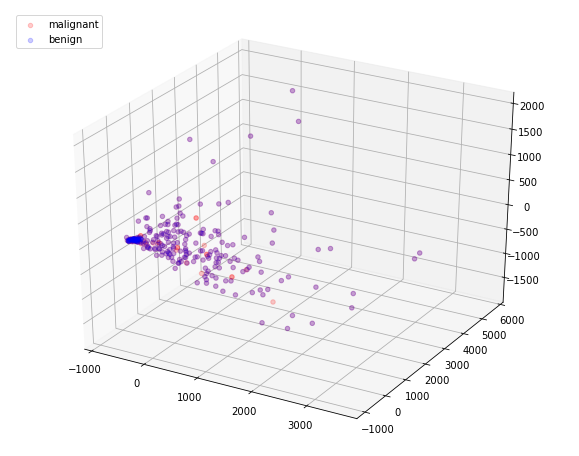

In [189]:
byplot(XX,df_full)

In [185]:
len(df_full[df_full['flag'] == 0])

250

In [165]:

pca = PCA(n_components=3)
X = pca.fit_transform(XX)


In [128]:
def create_df_from_pickle(pickle_file):
    with open(BASEFILE +pickle_file, 'rb') as f:
        results_ = pickle.load(f)
    results = pd.DataFrame(columns=['movie', 'count', 'full'], data=results_)
    start_time = datetime.datetime.strptime(pickle_file , 'video_Record-%Y-%m-%d_%H-%M-%S.avi_full.pickle')
    time_per_frame =  datetime.timedelta(seconds= 1/ video_fps)
    results['datetime'] = [start_time + time_per_frame * (i+1)  for i in results['count']]
    frame_flag_dates = []
    flags = []
    for frame_date in tqdm(results['datetime'].values):
        frame_flag_date = pd.to_datetime(frame_date) - (pd.to_datetime(frame_date)  - datetime.datetime(2018, 2,15, 8) ) % datetime.timedelta(seconds=8)
        flag = df[df['datetime'].isin([frame_flag_date])]['flag'].values
        if list(flag) == []:
            flags.append(None)
        else:
            flags.append(flag[0])
        frame_flag_dates.append(frame_flag_date)
    results['flag_datetime'] = frame_flag_dates
    results['flag'] = flags
    return results

In [130]:
import datetime

In [139]:
BASEFILE = 'Movie4/'
movies = !ls $BASEFILE | grep .avi | grep -v pickle
pickles =  !ls $BASEFILE | grep .avi | grep  pickle
csv_file = !ls $BASEFILE | grep csv
df = pd.read_csv(BASEFILE + csv_file[0], header=7)
df['time'] = ['{}:{}:{}'.format(i*8//3600, ( i * 8 //60) % 60, i * 8 %60) for i in df.index]
df['flag'] = [0 if flag == 'Wake' else (1 if flag =='REM' else 2) for flag in df[df.columns[0]]]
df['datetime'] = [datetime.datetime(2018, 2, 15, 8) +  datetime.timedelta(seconds=i * 8) for i in df.index]

In [140]:
BASEFILE = 'Movie/'
df1 = create_df_from_pickle( 'video_Record-2018-02-15_08-53-59.avi_full.pickle')
df2 = create_df_from_pickle('video_Record-2018-02-15_10-06-28.avi_full.pickle')
df_full  = pd.concat([df1,df2], axis=0)

100%|██████████| 250/250 [00:00<00:00, 664.89it/s]


In [142]:
X = df_full['full'].values
y = df_full['flag'].values

In [143]:
XX = np.array([list(a) for a in X])

In [166]:
df_full['full'] = XX